# Regression Metrics
    
    Measuring Prediction Quality Beyond a Single Number
    
## Objective

This notebook provides a systematic and decision-oriented treatment of regression evaluation metrics, covering:

- Error-based metrics (absolute, squared, relative)

- Scale-dependent vs scale-independent metrics

- Sensitivity to outliers

- Business interpretation of metrics

- When not to trust a metric

It answers:

     How do we evaluate regression models in a way that aligns with business impact and statistical validity?

## Why Regression Metrics Matter

Choosing the wrong metric can:

- Reward bad models

- Hide large errors

- Penalize useful models

- Misalign ML optimization with business goals

- Metrics are loss functions with assumptions, not neutral scores.

## Business Context

Regression metrics are used in:

- Revenue forecasting

- Credit risk (LGD, EAD)

- Pricing models

- Demand planning

- Time-to-event estimation

Different contexts require different error tolerance profiles.

## Imports and Dataset

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Superviased-regression/synthetic_customer_ltv_regression_complete.csv")
df.head()

,customer_id,signup_year,signup_month,days_since_signup,tenure_months,avg_monthly_spend,purchase_frequency,discount_sensitivity,returns_rate,email_open_rate,ad_click_rate,loyalty_score,support_tickets,churn_risk_score,credit_score_proxy,customer_lifetime_value
0,1,2022,8,899.094991,29,123.916907,3,0.401322,0.043396,0.042156,0.023647,0.123574,1,0.959716,671.029435,2691.193107
1,2,2019,9,2017.615223,66,204.814055,5,0.266840,0.338968,0.540674,0.180153,0.323954,1,0.789270,746.074773,11690.801889
2,3,2020,3,1720.937794,57,218.905816,3,0.028719,0.041845,0.517227,0.173583,0.268430,2,0.533410,601.164043,13094.093874
3,4,2022,3,1001.962036,33,188.028060,4,0.421602,0.140611,0.512366,0.277571,0.498941,3,0.699054,722.688139,6251.644013
4,5,2018,4,2522.620983,84,142.413565,6,0.192419,0.051116,0.462827,0.123844,0.500634,2,0.439348,659.860235,16474.610236


In [4]:
df.columns = ['customer_id', 'signup_year', 'signup_month', 'days_since_signup',
       'tenure_months', 'avg_monthly_spend', 'purchase_frequency',
       'discount_sensitivity', 'returns_rate', 'email_open_rate',
       'ad_click_rate', 'loyalty_score', 'support_tickets', 'churn_risk_score',
       'credit_score_proxy', "customer_value"]



X = df.drop(columns=["customer_value", "customer_id"])
y = df["customer_value"]

In [11]:
# Train Test Split


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=2010
)


# Baseline Model (Reference)

We use a simple linear regression as a baseline.

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


## Mean Absolute Error (MAE)
Definition


> $MSE = \frac{1}{n} \sum(y - \bar{y})^2$



**Properties**

- ✔ Same unit as target
- ✔ Robust to outliers
-`[Con`] Penalizes small and large errors equally

In [13]:
mse = mean_squared_error(y_test, y_pred)
mse


6654920.775651502

## Root Mean Squared Error (RMSE)



> $RMSE = \sqrt{MSE}$


**Properties**:

- ✔ Same unit as target

- ✔ Emphasizes tail risk

- ❌ Dominated by large errors

In [23]:
mse = mean_squared_error(y_test, y_pred)#, squared=False)
rmse = np.sqrt(mse)
rmse


np.float64(2579.7133126864123)

- Used heavily in finance and forecasting.

## R² (Coefficient of Determination)



> $R^2 = 1 - \frac{SS_{residual}}{SS_{total}}$


**Properties**

- ✔ Scale-free
- ✔ Easy to communicate
- ❌ Can be misleading
- ❌ Not a loss function

In [24]:
r2 = r2_score(y_test, y_pred)
r2


0.839469727628931

## Adjusted R² (Conceptual)

Adjusted R² penalizes unnecessary complexity.


>  $ R^{2}_{adj}      =  1 - (1 - R) \frac{n - 1}{n - p -1}$



Mostly used in statistical modeling, not ML pipelines.

## Mean Absolute Percentage Error (MAPE)




>   $  MAPE = \frac{1}{n} \sum{|\frac{y - \bar{y}}{y}|}     $


Properties

- ✔ Scale-independent
- ✔ Easy for stakeholders
- ❌ Breaks near zero
- ❌ Biased toward low values

In [25]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape


0.7342740302862982

## Error Distribution Analysis

Metrics alone hide structure.

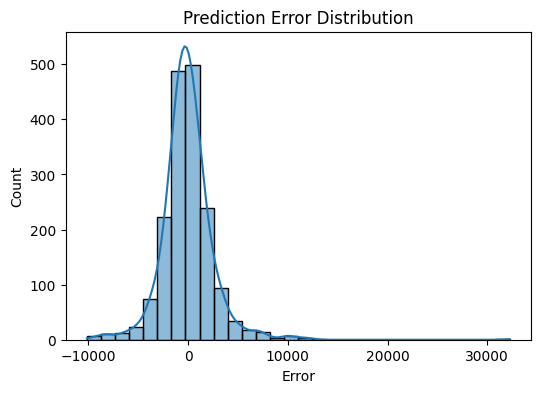

In [26]:
errors = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=30, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.show()


Look for:

- Bias (shifted mean)

- Heavy tails

- Asymmetry

## Residuals vs Predictions

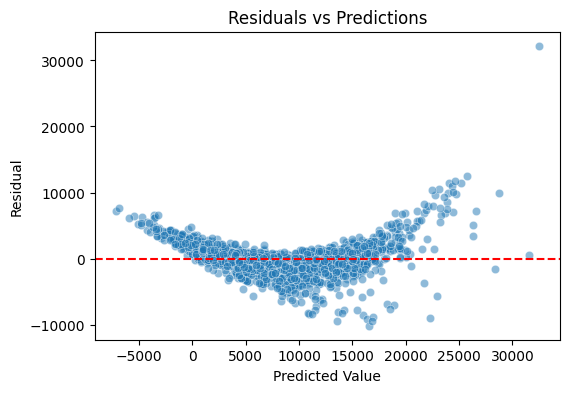

In [27]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=errors, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residuals vs Predictions")
plt.show()


Patterns indicate model misspecification.

## Metric Sensitivity to Outliers (Demonstration)

In [30]:
y_test_outlier = y_test.copy()
y_test_outlier.iloc[0] *= 10  # inject outlier

print("MAE:", mean_absolute_error(y_test_outlier, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_outlier, y_pred)))#, squared=False))


MAE: 1747.2192286768236
RMSE: 2595.680920013518


- ✔ RMSE explodes
- ✔ MAE remains stable

## Metric Selection by Use Case

| Use Case              | Recommended Metric |
| --------------------- | ------------------ |
| Forecasting           | RMSE               |
| Pricing               | MAE                |
| Risk modeling         | MAE + RMSE         |
| Stakeholder reporting | MAPE (carefully)   |
| Model comparison      | Multiple metrics   |


## Common Mistakes (Avoided)

- ❌ Using R² alone
- ❌ Optimizing for MSE blindly
- ❌ Ignoring residual structure
- ❌ Comparing metrics across datasets
- ❌ Treating metrics as business KPIs

## Summary Table

| Metric | Unit    | Outlier Sensitivity | Use          |
| ------ | ------- | ------------------- | ------------ |
| MAE    | Target  | Low                 | General      |
| MSE    | Squared | Very High           | Optimization |
| RMSE   | Target  | High                | Forecasting  |
| R²     | None    | Medium              | Explanation  |
| MAPE   | %       | High                | Reporting    |


# Key Takeaways

- No single metric is sufficient

- Metrics encode assumptions

- Always inspect residuals

- Align metric choice with business risk

- Use multiple metrics for validation

06_Model_Evaluation_and_Validation/

└── [02_classification_metrics.ipynb](02_classification_metrics)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)